In [ ]:
#| default_exp pinn.core
#| default_cls_lvl 3

In [ ]:
#| export
import torch
from fastai.learner import Callback
import numpy as np

## Excitation Signal Generation

Functions for generating standard excitation signals used in system identification and PINN collocation points.


In [ ]:
#| export
DEFAULT_SIGNAL_TYPES = ['sine', 'multisine', 'step', 'ramp', 'chirp', 'noise', 'prbs', 'square', 'doublet']

DEFAULT_SIGNAL_PARAMS = {
    'sine': {'phase_range': (0, 2*np.pi)},
    'multisine': {'n_components': 3},
    'step': {'time_range': (0.2, 0.8)},
    'ramp': {'slope_range': (-0.5, 0.5), 'start_time_range': (0.1, 0.6)},
    'chirp': {'f0_range': (0.1, 1.0), 'f1_range': (1.0, 5.0)},
    'prbs': {'switch_probability': 0.02},
    'square': {'duty_cycle_range': (0.3, 0.7)},
    'doublet': {'duration_range': (0.05, 0.2), 'start_time_range': (0.2, 0.5)}
}

def _generate_sine(
    seq_length:int, # Length of sequence
    dt:float, # Time step
    amplitudes:np.ndarray, # Signal amplitudes [num_signals]
    frequencies:np.ndarray, # Frequencies in Hz [num_signals]
    phases:np.ndarray # Phase offsets in radians [num_signals]
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple sine waves vectorized'''
    t = np.arange(seq_length) * dt
    return amplitudes[:, np.newaxis] * np.sin(2 * np.pi * frequencies[:, np.newaxis] * t + phases[:, np.newaxis])

def _generate_multisine(
    seq_length:int, # Length of sequence
    dt:float, # Time step
    amplitudes:np.ndarray, # Total signal amplitudes [num_signals]
    all_frequencies:list # List of frequency arrays, one per signal
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple multisine signals vectorized'''
    num_signals = len(amplitudes)
    t = np.arange(seq_length) * dt
    signals = np.zeros((num_signals, seq_length))
    for i in range(num_signals):
        freqs = all_frequencies[i]
        amp_per_component = amplitudes[i] / len(freqs)
        for freq in freqs:
            signals[i] += amp_per_component * np.sin(2 * np.pi * freq * t)
    return signals

def _generate_step(
    seq_length:int, # Length of sequence
    amplitudes:np.ndarray, # Step amplitudes [num_signals]
    step_indices:np.ndarray # Indices where step occurs [num_signals]
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple step signals vectorized'''
    num_signals = len(amplitudes)
    signals = np.zeros((num_signals, seq_length))
    for i in range(num_signals):
        signals[i, step_indices[i]:] = amplitudes[i]
    return signals

def _generate_ramp(
    seq_length:int, # Length of sequence
    amplitudes:np.ndarray, # Final amplitudes [num_signals]
    slopes:np.ndarray, # Slopes of ramps [num_signals]
    start_indices:np.ndarray # Start indices of ramps [num_signals]
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple ramp signals vectorized'''
    num_signals = len(amplitudes)
    signals = np.zeros((num_signals, seq_length))
    for i in range(num_signals):
        start_idx = start_indices[i]
        ramp_length = seq_length - start_idx
        signals[i, start_idx:] = slopes[i] * np.arange(ramp_length)
        signals[i] = np.clip(signals[i], -abs(amplitudes[i]), abs(amplitudes[i]))
    return signals

def _generate_chirp(
    seq_length:int, # Length of sequence
    dt:float, # Time step
    amplitudes:np.ndarray, # Signal amplitudes [num_signals]
    f0s:np.ndarray, # Start frequencies [num_signals]
    f1s:np.ndarray # End frequencies [num_signals]
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple chirp signals vectorized'''
    t = np.arange(seq_length) * dt
    duration = seq_length * dt
    k = (f1s - f0s) / duration
    phases = 2 * np.pi * (f0s[:, np.newaxis] * t + 0.5 * k[:, np.newaxis] * t * t)
    return amplitudes[:, np.newaxis] * np.sin(phases)

def _generate_noise(
    seq_length:int, # Length of sequence
    amplitudes:np.ndarray # Noise amplitudes (std) [num_signals]
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple Gaussian white noise signals vectorized'''
    num_signals = len(amplitudes)
    return amplitudes[:, np.newaxis] * np.random.randn(num_signals, seq_length)

def _generate_prbs(
    seq_length:int, # Length of sequence
    amplitudes:np.ndarray, # Signal amplitudes [num_signals]
    switch_probs:np.ndarray # Probabilities of switching per time step [num_signals]
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple PRBS signals'''
    num_signals = len(amplitudes)
    signals = np.zeros((num_signals, seq_length))
    for i in range(num_signals):
        current_level = amplitudes[i] if np.random.rand() < 0.5 else -amplitudes[i]
        signals[i, 0] = current_level
        for j in range(1, seq_length):
            if np.random.rand() < switch_probs[i]:
                current_level = -current_level
            signals[i, j] = current_level
    return signals

def _generate_square(
    seq_length:int, # Length of sequence
    dt:float, # Time step
    amplitudes:np.ndarray, # Signal amplitudes [num_signals]
    frequencies:np.ndarray, # Frequencies in Hz [num_signals]
    duty_cycles:np.ndarray # Duty cycles (0-1) [num_signals]
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple square wave signals vectorized'''
    t = np.arange(seq_length) * dt
    periods = 1.0 / frequencies
    phases = (t[np.newaxis, :] % periods[:, np.newaxis]) / periods[:, np.newaxis]
    return amplitudes[:, np.newaxis] * ((phases < duty_cycles[:, np.newaxis]).astype(float) * 2 - 1)

def _generate_doublet(
    seq_length:int, # Length of sequence
    amplitudes:np.ndarray, # Pulse amplitudes [num_signals]
    duration_indices:np.ndarray, # Duration of pulse in samples [num_signals]
    start_indices:np.ndarray # Start indices of pulses [num_signals]
) -> np.ndarray: # Signals [num_signals, seq_length]
    '''Generate multiple doublet signals'''
    num_signals = len(amplitudes)
    signals = np.zeros((num_signals, seq_length))
    for i in range(num_signals):
        end_idx = min(start_indices[i] + duration_indices[i], seq_length)
        signals[i, start_indices[i]:end_idx] = amplitudes[i]
    return signals


In [ ]:
#| export
def generate_excitation_signals(
    batch_size:int, # Number of sequences in batch
    seq_length:int, # Length of each sequence
    n_inputs:int = 1, # Number of input dimensions
    dt:float = 0.01, # Time step
    device:str = 'cpu', # Device for tensors
    signal_types:list = None, # Signal types to use (None = all core types)
    amplitude_range:tuple = (0.5, 2.0), # Global amplitude range
    frequency_range:tuple = (0.1, 3.0), # Global frequency range
    input_configs:list = None, # Per-input configuration (list of dicts)
    noise_probability:float = 0.0, # Probability of adding noise per sequence
    noise_std_range:tuple = (0.05, 0.15), # Noise std as fraction of amplitude
    bias_probability:float = 0.0, # Probability of adding DC bias per sequence
    bias_range:tuple = (-0.5, 0.5), # DC bias range
    synchronized_inputs:bool = False, # If True, all inputs get same signal type
    seed:int = None # Random seed
) -> torch.Tensor: # Returns [batch_size, seq_length, n_inputs]
    '''Generate standard excitation signals for PINN collocation points (vectorized)'''
    if seed is not None:
        np.random.seed(seed)
    
    signal_types = signal_types or DEFAULT_SIGNAL_TYPES
    total_signals = batch_size * n_inputs
    
    # Build configuration for each signal
    configs = []
    for batch_idx in range(batch_size):
        for input_idx in range(n_inputs):
            if input_configs and input_idx < len(input_configs):
                input_cfg = input_configs[input_idx]
                configs.append({
                    'amplitude_range': input_cfg.get('amplitude_range', amplitude_range),
                    'frequency_range': input_cfg.get('frequency_range', frequency_range),
                    'signal_types': input_cfg.get('signal_types', signal_types),
                    'signal_params': input_cfg.get('signal_params', {})
                })
            else:
                configs.append({
                    'amplitude_range': amplitude_range,
                    'frequency_range': frequency_range,
                    'signal_types': signal_types,
                    'signal_params': {}
                })
    
    # Pre-sample signal types (handling synchronized_inputs)
    signal_type_choices = np.empty(total_signals, dtype=object)
    if synchronized_inputs:
        for batch_idx in range(batch_size):
            sig_type = np.random.choice(signal_types)
            for input_idx in range(n_inputs):
                idx = batch_idx * n_inputs + input_idx
                signal_type_choices[idx] = sig_type
    else:
        for idx, cfg in enumerate(configs):
            signal_type_choices[idx] = np.random.choice(cfg['signal_types'])
    
    # Pre-sample amplitudes
    amplitudes = np.array([np.random.uniform(*cfg['amplitude_range']) for cfg in configs])
    
    # Group signals by type
    result = np.zeros((total_signals, seq_length))
    for sig_type in set(signal_type_choices):
        indices = np.where(signal_type_choices == sig_type)[0]
        if len(indices) == 0:
            continue
        
        type_amps = amplitudes[indices]
        type_configs = [configs[i] for i in indices]
        
        # Generate based on signal type
        if sig_type == 'sine':
            freqs = np.array([np.random.uniform(*cfg['signal_params'].get('sine', {}).get('frequency_range', cfg['frequency_range'])) 
                             for cfg in type_configs])
            phases = np.array([np.random.uniform(*cfg['signal_params'].get('sine', {}).get('phase_range', DEFAULT_SIGNAL_PARAMS['sine']['phase_range'])) 
                              for cfg in type_configs])
            result[indices] = _generate_sine(seq_length, dt, type_amps, freqs, phases)
        
        elif sig_type == 'multisine':
            all_freqs = []
            for cfg in type_configs:
                n_comp = cfg['signal_params'].get('multisine', {}).get('n_components', DEFAULT_SIGNAL_PARAMS['multisine']['n_components'])
                freq_range = cfg['signal_params'].get('multisine', {}).get('frequency_range', cfg['frequency_range'])
                all_freqs.append(np.random.uniform(*freq_range, size=n_comp))
            result[indices] = _generate_multisine(seq_length, dt, type_amps, all_freqs)
        
        elif sig_type == 'step':
            time_ranges = np.array([[*cfg['signal_params'].get('step', {}).get('time_range', DEFAULT_SIGNAL_PARAMS['step']['time_range'])] 
                                   for cfg in type_configs])
            step_times = np.random.uniform(time_ranges[:, 0], time_ranges[:, 1])
            step_indices = (step_times * seq_length).astype(int)
            result[indices] = _generate_step(seq_length, type_amps, step_indices)
        
        elif sig_type == 'ramp':
            slope_ranges = np.array([[*cfg['signal_params'].get('ramp', {}).get('slope_range', DEFAULT_SIGNAL_PARAMS['ramp']['slope_range'])] 
                                    for cfg in type_configs])
            start_time_ranges = np.array([[*cfg['signal_params'].get('ramp', {}).get('start_time_range', DEFAULT_SIGNAL_PARAMS['ramp']['start_time_range'])] 
                                         for cfg in type_configs])
            slopes = np.random.uniform(slope_ranges[:, 0], slope_ranges[:, 1])
            start_times = np.random.uniform(start_time_ranges[:, 0], start_time_ranges[:, 1])
            start_indices = (start_times * seq_length).astype(int)
            result[indices] = _generate_ramp(seq_length, type_amps, slopes, start_indices)
        
        elif sig_type == 'chirp':
            f0_ranges = np.array([[*cfg['signal_params'].get('chirp', {}).get('f0_range', DEFAULT_SIGNAL_PARAMS['chirp']['f0_range'])] 
                                 for cfg in type_configs])
            f1_ranges = np.array([[*cfg['signal_params'].get('chirp', {}).get('f1_range', DEFAULT_SIGNAL_PARAMS['chirp']['f1_range'])] 
                                 for cfg in type_configs])
            f0s = np.random.uniform(f0_ranges[:, 0], f0_ranges[:, 1])
            f1s = np.random.uniform(f1_ranges[:, 0], f1_ranges[:, 1])
            result[indices] = _generate_chirp(seq_length, dt, type_amps, f0s, f1s)
        
        elif sig_type == 'noise':
            result[indices] = _generate_noise(seq_length, type_amps)
        
        elif sig_type == 'prbs':
            switch_probs = np.array([cfg['signal_params'].get('prbs', {}).get('switch_probability', DEFAULT_SIGNAL_PARAMS['prbs']['switch_probability']) 
                                    for cfg in type_configs])
            result[indices] = _generate_prbs(seq_length, type_amps, switch_probs)
        
        elif sig_type == 'square':
            freqs = np.array([np.random.uniform(*cfg['signal_params'].get('square', {}).get('frequency_range', cfg['frequency_range'])) 
                             for cfg in type_configs])
            duty_cycle_ranges = np.array([[*cfg['signal_params'].get('square', {}).get('duty_cycle_range', DEFAULT_SIGNAL_PARAMS['square']['duty_cycle_range'])] 
                                         for cfg in type_configs])
            duty_cycles = np.random.uniform(duty_cycle_ranges[:, 0], duty_cycle_ranges[:, 1])
            result[indices] = _generate_square(seq_length, dt, type_amps, freqs, duty_cycles)
        
        elif sig_type == 'doublet':
            duration_ranges = np.array([[*cfg['signal_params'].get('doublet', {}).get('duration_range', DEFAULT_SIGNAL_PARAMS['doublet']['duration_range'])] 
                                       for cfg in type_configs])
            start_time_ranges = np.array([[*cfg['signal_params'].get('doublet', {}).get('start_time_range', DEFAULT_SIGNAL_PARAMS['doublet']['start_time_range'])] 
                                         for cfg in type_configs])
            durations = np.random.uniform(duration_ranges[:, 0], duration_ranges[:, 1])
            start_times = np.random.uniform(start_time_ranges[:, 0], start_time_ranges[:, 1])
            duration_indices = np.maximum(1, (durations * seq_length).astype(int))
            start_indices = (start_times * seq_length).astype(int)
            result[indices] = _generate_doublet(seq_length, type_amps, duration_indices, start_indices)
    
    # Vectorized composition: noise and bias
    if noise_probability > 0:
        noise_flags = np.random.rand(total_signals) < noise_probability
        if noise_flags.any():
            noise_stds = np.random.uniform(*noise_std_range, size=total_signals) * np.abs(amplitudes)
            noise_signals = _generate_noise(seq_length, noise_stds[noise_flags])
            result[noise_flags] += noise_signals
    
    if bias_probability > 0:
        bias_flags = np.random.rand(total_signals) < bias_probability
        if bias_flags.any():
            biases = np.random.uniform(*bias_range, size=bias_flags.sum())
            result[bias_flags] += biases[:, np.newaxis]
    
    # Reshape and convert to torch
    result = result.reshape(batch_size, n_inputs, seq_length).transpose(0, 2, 1)
    return torch.from_numpy(result).to(device).float()


### Example Usage

The `generate_excitation_signals` function generates standard excitation signals commonly used in system identification and control. It supports 9 signal types: sine, multisine, step, ramp, chirp, noise, prbs, square, and doublet.


In [ ]:
# Simple usage: all signal types with default configuration
u_simple = generate_excitation_signals(8, 200, n_inputs=2, dt=0.01)
print(f"Simple: {u_simple.shape}")  # [8, 200, 2]

# Battery model: different ranges for current and temperature
input_configs_battery = [
    {'amplitude_range': (0, 5)},  # Current (A)
    {'amplitude_range': (15, 45),  # Temperature (°C)
     'signal_params': {
         'sine': {'frequency_range': (0.01, 0.1)}  # Slow temperature changes
     }}
]
u_battery = generate_excitation_signals(8, 200, n_inputs=2, dt=0.01,
                                       input_configs=input_configs_battery,
                                       noise_probability=0.3)
print(f"Battery model: {u_battery.shape}")  # [8, 200, 2]


Simple: torch.Size([8, 200, 2])
Battery model: torch.Size([8, 200, 2])


[<matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>]

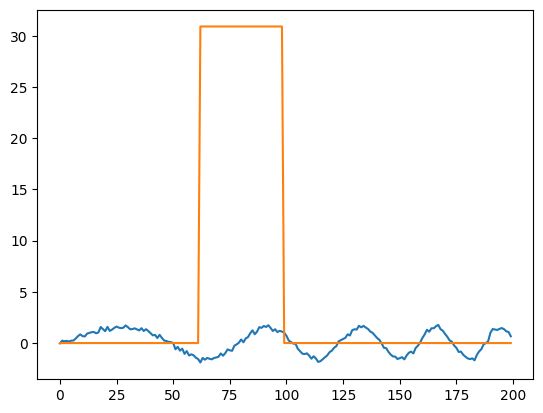

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(u_battery[1])

## Random State Generation

Helper function for generating random physical states for PINN collocation points.


In [ ]:
#| export
def generate_random_states(
    batch_size:int, # Number of states to generate
    n_outputs:int, # Number of output dimensions
    output_ranges:list, # List of (min, max) tuples for each dimension
    device:str = 'cpu', # Device for tensor
    seed:int = None # Random seed
) -> torch.Tensor: # Returns [batch_size, n_outputs]
    '''Generate random physical states for PINN collocation points'''
    if seed is not None:
        np.random.seed(seed)
    
    # Ensure output_ranges is a list
    if not isinstance(output_ranges, list):
        output_ranges = [output_ranges] * n_outputs
    
    states = np.zeros((batch_size, n_outputs))
    for i in range(n_outputs):
        min_val, max_val = output_ranges[i]
        states[:, i] = np.random.uniform(min_val, max_val, batch_size)
    
    return torch.from_numpy(states).to(device).float()


## Numerical Differencing Function 

In [ ]:
#| export
@torch.jit.script
def diff1_forward(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    First-order forward difference (JIT-compiled).
    f'(x) ≈ (f(x+h) - f(x)) / h
    Accuracy: O(dt)
    """
    interior = (signal[:, 1:] - signal[:, :-1]) / dt
    last = interior[:, -1:]
    return torch.cat([interior, last], dim=1,)

@torch.jit.script
def diff1_forward_double(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    First-order forward difference (JIT-compiled).
    f'(x) ≈ (f(x+h) - f(x)) / h
    Accuracy: O(dt)
    """
    signal_double = signal.type(torch.float64)
    interior = (signal_double[:, 1:] - signal_double[:, :-1]) / dt
    last = interior[:, -1:]
    return torch.cat([interior, last], dim=1,).type(signal.dtype)

@torch.jit.script
def diff1_central(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    First-order central difference (JIT-compiled).
    f'(x) ≈ (f(x+h) - f(x-h)) / (2h)
    Accuracy: O(dt²)
    """
    dt2 = 2.0 * dt
    interior = (signal[:, 2:] - signal[:, :-2]) / dt2
    first = (signal[:, 1:2] - signal[:, 0:1]) / dt
    last = (signal[:, -1:] - signal[:, -2:-1]) / dt
    return torch.cat([first, interior, last], dim=1)

@torch.jit.script
def diff1_central4_double(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    4th-order central difference: 
    f'(x) ≈ (-f(x+2h) + 8f(x+h) - 8f(x-h) + f(x-2h)) / (12h)
    Accuracy: O(dt⁴)
    """
    signal_double = signal.type(torch.float64)
    
    # 4th order central for interior
    interior = (
        -signal_double[:, 4:] 
        + 8 * signal_double[:, 3:-1]
        - 8 * signal_double[:, 1:-3]
        + signal_double[:, :-4]
    ) / (12 * dt)
    
    # Handle boundaries with lower-order approximations
    # Second-order central for points 1 and -2
    point1 = (signal_double[:, 2:3] - signal_double[:, 0:1]) / (2 * dt)
    point_m2 = (signal_double[:, -1:] - signal_double[:, -3:-2]) / (2 * dt)
    
    # Forward/backward difference for edges
    first = (signal_double[:, 1:2] - signal_double[:, 0:1]) / dt
    last = (signal_double[:, -1:] - signal_double[:, -2:-1]) / dt
    
    return torch.cat([first, point1, interior, point_m2, last], dim=1).type(signal.dtype)
    
@torch.jit.script
def diff2_forward(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    Second-order forward difference (JIT-compiled).
    f''(x) ≈ (f(x+2h) - 2f(x+h) + f(x)) / h²
    Accuracy: O(dt)
    """
    dt_sq = dt * dt
    interior = (signal[:, 2:] - 2.0 * signal[:, 1:-1] + signal[:, :-2]) / dt_sq
    first = (signal[:, 2:3] - 2.0 * signal[:, 1:2] + signal[:, 0:1]) / dt_sq
    last = (signal[:, -1:] - 2.0 * signal[:, -2:-1] + signal[:, -3:-2]) / dt_sq
    return torch.cat([first, interior, last], dim=1)


@torch.jit.script
def diff2_central(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    Second-order central difference (JIT-compiled).
    f''(x) ≈ (f(x+h) - 2f(x) + f(x-h)) / h²
    Accuracy: O(dt²)
    """
    dt_sq = dt * dt
    interior = (signal[:, 2:] - 2.0 * signal[:, 1:-1] + signal[:, :-2]) / dt_sq
    first = (signal[:, 2:3] - 2.0 * signal[:, 1:2] + signal[:, 0:1]) / dt_sq
    last = (signal[:, -1:] - 2.0 * signal[:, -2:-1] + signal[:, -3:-2]) / dt_sq
    return torch.cat([first, interior, last], dim=1)


@torch.jit.script
def diff2_central_double(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    Second-order central difference (JIT-compiled).
    f''(x) ≈ (f(x+h) - 2f(x) + f(x-h)) / h²
    Accuracy: O(dt²)
    """
    dt_sq = dt * dt
    signal_double = signal.type(torch.float64)
    interior = (signal_double[:, 2:] - 2.0 * signal_double[:, 1:-1] + signal_double[:, :-2]) / dt_sq
    first = (signal_double[:, 2:3] - 2.0 * signal_double[:, 1:2] + signal_double[:, 0:1]) / dt_sq
    last = (signal_double[:, -1:] - 2.0 * signal_double[:, -2:-1] + signal_double[:, -3:-2]) / dt_sq
    return torch.cat([first, interior, last], dim=1,).type(signal.dtype)

@torch.jit.script
def diff3_forward(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    Third-order forward difference (JIT-compiled).
    f'''(x) ≈ (f(x+3h) - 3f(x+2h) + 3f(x+h) - f(x)) / h³
    Accuracy: O(dt)
    """
    dt_cb = dt * dt * dt
    interior = (signal[:, 3:] - 3.0 * signal[:, 2:-1] + 3.0 * signal[:, 1:-2] - signal[:, :-3]) / dt_cb
    first = (signal[:, 3:4] - 3.0 * signal[:, 2:3] + 3.0 * signal[:, 1:2] - signal[:, 0:1]) / dt_cb
    second = first
    last = (signal[:, -1:] - 3.0 * signal[:, -2:-1] + 3.0 * signal[:, -3:-2] - signal[:, -4:-3]) / dt_cb
    return torch.cat([first, second, interior, last], dim=1)


@torch.jit.script
def diff3_central(signal: torch.Tensor, dt: float) -> torch.Tensor:
    """
    Third-order central difference (JIT-compiled).
    f'''(x) ≈ (f(x+2h) - 2f(x+h) + 2f(x-h) - f(x-2h)) / (2h³)
    Accuracy: O(dt²)
    """
    dt_cb = 2.0 * dt * dt * dt
    interior = (signal[:, 4:] - 2.0 * signal[:, 3:-1] + 2.0 * signal[:, 1:-3] - signal[:, :-4]) / dt_cb
    
    # Boundary using forward formula
    dt_cb_fwd = dt * dt * dt
    d1 = (signal[:, 3:4] - 3.0 * signal[:, 2:3] + 3.0 * signal[:, 1:2] - signal[:, 0:1]) / dt_cb_fwd
    d2 = (signal[:, 4:5] - 2.0 * signal[:, 3:4] + 2.0 * signal[:, 1:2] - signal[:, 0:1]) / dt_cb
    d_n1 = (signal[:, -1:] - 2.0 * signal[:, -2:-1] + 2.0 * signal[:, -4:-3] - signal[:, -5:-4]) / dt_cb
    d_n = (signal[:, -1:] - 3.0 * signal[:, -2:-1] + 3.0 * signal[:, -3:-2] - signal[:, -4:-3]) / dt_cb_fwd
    
    return torch.cat([d1, d2, interior, d_n1, d_n], dim=1)

## Callbacks

In [ ]:
#| export
class PhysicsLossCallback(Callback):
    "`Callback` that adds physics-informed loss using actual training data"
    def __init__(self, 
                 norm_input, # Normalizer with `.mean` and `.std` for denormalization
                 physics_loss_func, # Function(u, y_pred, y_ref) -> dict of losses or single loss tensor
                 weight: float = 1.0, # Global scaling factor for physics loss contribution
                 loss_weights: dict = None, # Per-component weights like {'physics': 1.0, 'derivative': 0.1}
                 n_inputs: int = None # Number of input channels (if using concatenated inputs like FranSysLearner)
                ):
        '''Apply physics-informed loss to training batches after denormalizing inputs'''
        self.mean = norm_input.mean
        self.std = norm_input.std
        self.weight = weight
        self.loss_weights = loss_weights or {}
        self.physics_loss_func = physics_loss_func
        self.n_inputs = n_inputs

    def after_loss(self):
        '''Compute physics-informed loss on training data and add to total loss'''
        if not self.training: return
        
        x_norm = self.xb[0]
        device = x_norm.device
        
        # Extract input part (if n_inputs specified, split concatenated input)
        if self.n_inputs is not None:
            u_norm = x_norm[:, :, :self.n_inputs]
        else:
            u_norm = x_norm
        
        # Denormalize input to physical space
        mean, std = self.mean.to(device), self.std.to(device)
        u = u_norm * std + mean
        
        # Get predictions and ground truth
        y_pred = self.pred
        y_ref = self.yb[0]
        
        # Compute physics losses (system-specific)
        loss_dict = self.physics_loss_func(u, y_pred, y_ref)
        
        # Handle both dict and single tensor returns
        if isinstance(loss_dict, dict):
            physics_total = sum(
                self.loss_weights.get(k, 1.0) * v 
                for k, v in loss_dict.items()
            )
        else:
            physics_total = loss_dict
        
        # Add weighted physics loss to main loss
        self.learn.loss = self.learn.loss + self.weight * physics_total
        self.learn.loss_grad = self.learn.loss_grad + self.weight * physics_total


## Example: Spring-Damper System

This example demonstrates training a neural network to model a mass-spring-damper system using physics-informed neural networks (PINN). The system follows: $ma + cv + kx = u$, where:
- $m$ = mass, $k$ = spring constant, $c$ = damping coefficient
- $x$ = position, $v$ = velocity, $a$ = acceleration
- $u$ = forcing input

**Important**: This example assumes zero initial conditions ($x_0=0, v_0=0$) and uses full sequences starting at index 0, since the model doesn't observe state information.


In [ ]:
from tsfast.basics import *
from tsfast.datasets.core import create_dls
from tsfast.models.rnn import RNNLearner
from tsfast.learner.losses import zero_loss, fun_rmse

# Physical parameters (must match dataset generation)
DT = 0.01
MASS = 1.0
SPRING_K = 1.0
DAMPING_C = 0.1

def spring_damper_physics(u, y_pred, y_ref) -> dict: # Dictionary of physics loss components
    '''Compute physics-informed loss for spring-damper system'''
    x, v = y_pred[:, :, 0], y_pred[:, :, 1]
    u = u.squeeze(-1)
    
    a = diff1_forward(v, DT)
    dx_dt = diff1_forward(x, DT)
    return {
        'physics': ((MASS*a + DAMPING_C*v + SPRING_K*x - u)**2).mean(),
        'derivative': ((v - dx_dt)**2).mean(),
        'initial': (x[:, 0]**2 + v[:, 0]**2).mean()
    }

# def spring_damper_physics(
#     y_pred:torch.Tensor, # Model predictions [batch, seq_len, 2] with (x, v)
#     u_phys:torch.Tensor, # Physical space inputs [batch, seq_len, 1]
#     learn # Learner instance (unused but available for advanced use)
# ) -> dict: # Dictionary of physics loss components
#     '''Compute physics-informed loss for spring-damper system'''
#     x = y_pred[:, :, 0]
#     u = u_phys.squeeze(-1)
#     v = diff1_forward_double(x, DT)
#     a = diff2_central_double(x, DT)
#     return {
#         'physics': ((MASS*a + DAMPING_C*v + SPRING_K*x - u)**2).mean(),
#         # 'derivative': ((v - dx_dt)**2).mean(),
#         'initial': (x[:, 0]**2 + v[:, 0]**2).mean()
#     }

# def spring_damper_physics(y_pred, u, learn):
#     x = y_pred
#     v = diff1_forward(x,DT)
#     a = diff2_central(x,DT)
#     return {
#         'physics': ((MASS*a + DAMPING_C*v + SPRING_K*x - u)**2).mean(),
#         # 'derivative': ((v - dx_dt)**2).mean(),
#         'initial': (x[:, 0]**2 + v[:, 0]**2).mean()
#     }

In [ ]:
# Load data - use full sequences starting at index 0 only
dls = create_dls(
    u=['u'], # Input signal names
    y=['x','v'], # Output signal names (position, velocity)
    dataset='../../test_data/pinn', # Path to dataset
    win_sz=500, # Full sequence length
    stp_sz=500, # Non-overlapping windows (ensures start at index 0)
    valid_stp_sz=500,
    bs=16, # Small batch size for testing
    n_batches_train=30 # Limit training batches
).cpu()


In [ ]:
# Create learner with standard MSE loss for data fitting
learn = RNNLearner(
    dls,
    rnn_type='gru',
    num_layers=1,
    hidden_size=10,
    loss_func=torch.nn.MSELoss(), # Standard loss for data fitting
    metrics=[fun_rmse]
)

# Add physics-informed loss on training data
learn.add_cb(PhysicsLossCallback(
    norm_input=dls.train.after_batch[0],
    physics_loss_func=spring_damper_physics,
    weight=1.0,
    loss_weights={'physics': 1.0, 'derivative': 1, 'initial': 1}
))

# Note: Typically you would also add CollocationPointsCB here to enforce
# physics on synthetic data for better generalization. See the full example
# in examples/pinn/train_pinn.ipynb

# Train briefly to verify it works
learn.fit_one_cycle(1, 3e-3)


epoch,train_loss,valid_loss,fun_rmse,time
0,1.514675,0.076960,0.277417,00:00


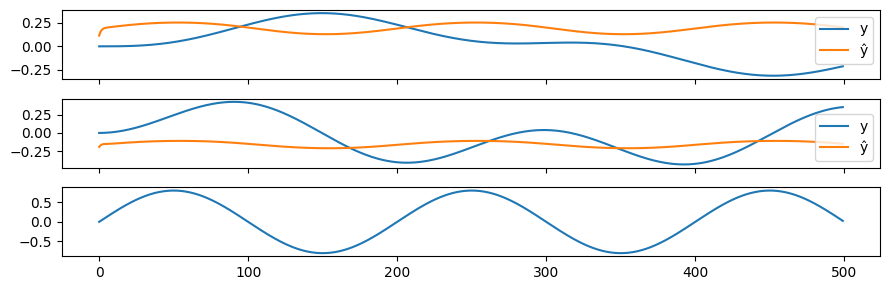

In [ ]:
# Visualize results
learn.show_results(max_n=1, ds_idx=1)

### Understanding the Two Callbacks

**PhysicsLossCallback**:
- Applies physics loss to **actual training data**
- Ensures the model respects physics on observed trajectories
- Requires denormalization of inputs before physics evaluation
- Essential for learning from real data while enforcing physics

**CollocationPointsCB**:
- Applies physics loss to **synthetic collocation points**
- Explores state space regions not covered by training data
- Useful when you can generate meaningful synthetic trajectories
- Improves generalization beyond training distribution

**Typical Usage Patterns**:
- **Most common**: Use **both callbacks together** with a standard loss (MSE/L1). Physics loss enforces physical consistency on both real and synthetic data while the standard loss ensures data fit.
- **Surrogate modeling**: Use `zero_loss` when training a surrogate model of a well-known differential equation where you only care about physics, not data fitting.
- The combination provides the best of both worlds: data fidelity + physics consistency + generalization.


In [ ]:
#| export
class CollocationPointsCB(Callback):
    "`Callback` that adds physics-informed loss using collocation points with user-defined physics"
    def __init__(self, 
                 norm_input, # Normalizer with `.mean` and `.std` attributes for input scaling
                 generate_pinn_input, # Function(batch_size, seq_len, device) -> tensor of collocation points
                 physics_loss_func, # Function(u, y_pred, y_ref) -> dict of losses or single loss tensor
                 weight:float = 1.0, # Global scaling factor for physics loss contribution
                 loss_weights:dict = None, # Per-component weights like {'physics': 1.0, 'derivative': 0.1}
                 num_workers:int = 2, # Number of parallel workers for collocation point generation
                 init_mode:str = 'none', # Initialization mode: 'none', 'state_encoder', or 'random_hidden'
                 output_ranges:list = None, # List of (min, max) tuples for random state generation
                 hidden_std:float = 0.1 # Std for random hidden state initialization
                ):
        '''Initialize callback with normalization, collocation generator, physics equations, and init mode'''
        self.mean = norm_input.mean
        self.std = norm_input.std
        self.weight = weight
        self.loss_weights = loss_weights or {}
        self.generate_pinn_input = generate_pinn_input
        self.physics_loss_func = physics_loss_func
        self.num_workers = num_workers
        self.loader_iter = None
        self.init_mode = init_mode
        self.output_ranges = output_ranges
        self.hidden_std = hidden_std

    def _prepare_loader(self, 
                       u_real # Sample tensor to infer batch_size and seq_length
                       ): # DataLoader with parallel workers
        "Create DataLoader with worker processes that continuously generate collocation points"
        class _Dataset(torch.utils.data.IterableDataset):
            def __init__(self, gen_fn, bs, seq_len):
                self.gen_fn = gen_fn
                self.bs = bs
                self.seq_len = seq_len
            
            def __iter__(self):
                while True:
                    yield self.gen_fn(self.bs, self.seq_len, 'cpu')
        
        loader = torch.utils.data.DataLoader(
            _Dataset(self.generate_pinn_input, u_real.shape[0], u_real.shape[1]),
            batch_size=None,
            num_workers=self.num_workers,
            prefetch_factor=2
        )
        return loader

    def after_loss(self):
        '''Compute physics-informed loss on collocation points and add to training loss'''
        if not self.training: return
        
        u_real = self.xb[0]
        device = u_real.device
        batch_size = u_real.shape[0]
        
        if self.loader_iter is None:
            self.loader_iter = iter(self._prepare_loader(u_real))
        
        u_coloc = next(self.loader_iter).to(device)
        mean, std = self.mean.to(device), self.std.to(device)
        u_norm = (u_coloc - mean) / std
        
        y_ref = None
        
        if self.init_mode == 'state_encoder':
            if self.output_ranges is None:
                raise ValueError("output_ranges must be provided when init_mode='state_encoder'")
            
            n_outputs = len(self.output_ranges)
            physical_states = generate_random_states(batch_size, n_outputs, self.output_ranges, device)
            
            if hasattr(self.learn.model, 'encode_single_state'):
                # Pass physical states directly - model will auto-detect and encode
                with torch.enable_grad():
                    y_pred = self.learn.model(u_norm, init_state=physical_states, encoder_mode='state')
                y_ref = physical_states.unsqueeze(1).expand(-1, u_coloc.shape[1], -1)
            else:
                raise ValueError("Model must have encode_single_state method for init_mode='state_encoder'")
                
        elif self.init_mode == 'random_hidden':
            if hasattr(self.learn.model, 'rnn_prognosis'):
                hidden_size = self.learn.model.hidden_size
                rnn_layer = self.learn.model.rnn_layer
                init_hidden = [torch.randn(1, batch_size, hidden_size, device=device) * self.hidden_std for _ in range(rnn_layer)]
                with torch.enable_grad():
                    y_pred = self.learn.model(u_norm, init_state=init_hidden, encoder_mode='none')
                y_ref = None
            else:
                raise ValueError("Model structure not compatible with init_mode='random_hidden'")
                
        else:
            with torch.enable_grad():
                y_pred = self.learn.model(u_norm)
            y_ref = None
        
        loss_dict = self.physics_loss_func(u_coloc, y_pred, y_ref)
        
        if isinstance(loss_dict, dict):
            physics_total = sum(self.loss_weights.get(k, 1.0) * v for k, v in loss_dict.items())
        else:
            physics_total = loss_dict
        
        self.learn.loss = self.learn.loss + self.weight * physics_total
        self.learn.loss_grad = self.learn.loss_grad + self.weight * physics_total

In [ ]:
#| export
from fastai.callback.hook import HookCallback
import torch.nn.functional as F

class ConsistencyCallback(HookCallback):
    '''Trains SequenceEncoder and StateEncoder compatibility on real data'''
    def __init__(self,
                 weight:float = 1.0, # Weight for consistency loss
                 match_at_timestep:int = None # Timestep to match hidden states (default: model.init_sz)
                ):
        '''Initialize consistency callback with loss weight'''
        super().__init__(modules=[])
        self.weight = weight
        self.match_at_timestep = match_at_timestep
        self._diag_out = None
    
    def before_fit(self):
        '''Set up hooks for diagnosis RNN if model supports it'''
        if hasattr(self.learn.model, 'rnn_diagnosis') and hasattr(self.learn.model, 'encode_single_state'):
            self.modules = [self.learn.model.rnn_diagnosis]
        else:
            self.modules = []
    
    def hook(self, m, i, o):
        '''Capture diagnosis RNN output'''
        self._diag_out = o[0]
    
    def after_loss(self):
        '''Compute consistency loss between SequenceEncoder and StateEncoder'''
        if not self.training: return
        if not self.modules: return
        if self._diag_out is None: return
        
        timestep = self.match_at_timestep
        if timestep is None and hasattr(self.learn.model, 'init_sz'):
            timestep = self.learn.model.init_sz - 1
        elif timestep is None:
            timestep = -1
        
        h_sequence = self.learn.model.rnn_diagnosis.output_to_hidden(self._diag_out, timestep)
        physical_state = self.yb[0][:, timestep, :]
        h_state = self.learn.model.encode_single_state(physical_state)
        
        consistency_loss = 0.0
        for h_seq, h_st in zip(h_sequence, h_state):
            consistency_loss += F.mse_loss(h_seq, h_st)
        
        self.learn.loss += self.weight * consistency_loss
        self.learn.loss_grad += self.weight * consistency_loss
        
        self._diag_out = None


In [ ]:
# Create learner with PhysicsLossCallback
learn = RNNLearner(
    dls,
    rnn_type='gru',
    num_layers=1,
    hidden_size=10,
    loss_func=zero_loss, 
    metrics=[fun_rmse]
)

# Add physics-informed loss using CollocationPointsCB
# Use generate_excitation_signals for standard excitation signals
learn.add_cb(CollocationPointsCB(
    norm_input=dls.train.after_batch[0],
    generate_pinn_input=lambda bs, sl, dev: generate_excitation_signals(
        bs, sl, n_inputs=1, dt=DT, device=dev,
        amplitude_range=(0.5, 2.0),
        frequency_range=(0.1, 3.0)
    ),
    physics_loss_func=spring_damper_physics,
    weight=1.0,
    loss_weights={'physics': 1.0, 'derivative': 1., 'initial': 1.}
))

# Train briefly to verify it works
learn.fit(1, 3e-3)

epoch,train_loss,valid_loss,fun_rmse,time
0,1.917972,0.000000,0.234185,00:02


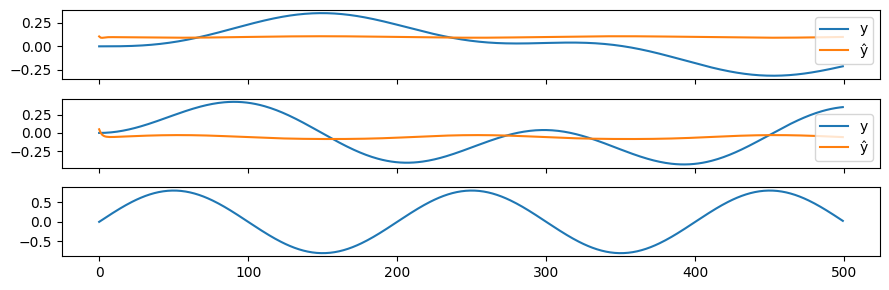

In [ ]:
learn.show_results(max_n=1, ds_idx=1)

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()